### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).



Часть 3: Распознавание
==



Первым этапом в этой части работы будет следующее:  обучим модель для распознавания лиц на основе датасета, который уже отдетектирован и выровнен по точкам, и посмотрим получившиеся метрики. 

Вторым этапом мы попробуем собрать наш пайплайн с обученной ранее моделью детекции и методом выравнивания лиц. 

Сравним качество наших моделей на распознавание лиц.

**RESNET-50**
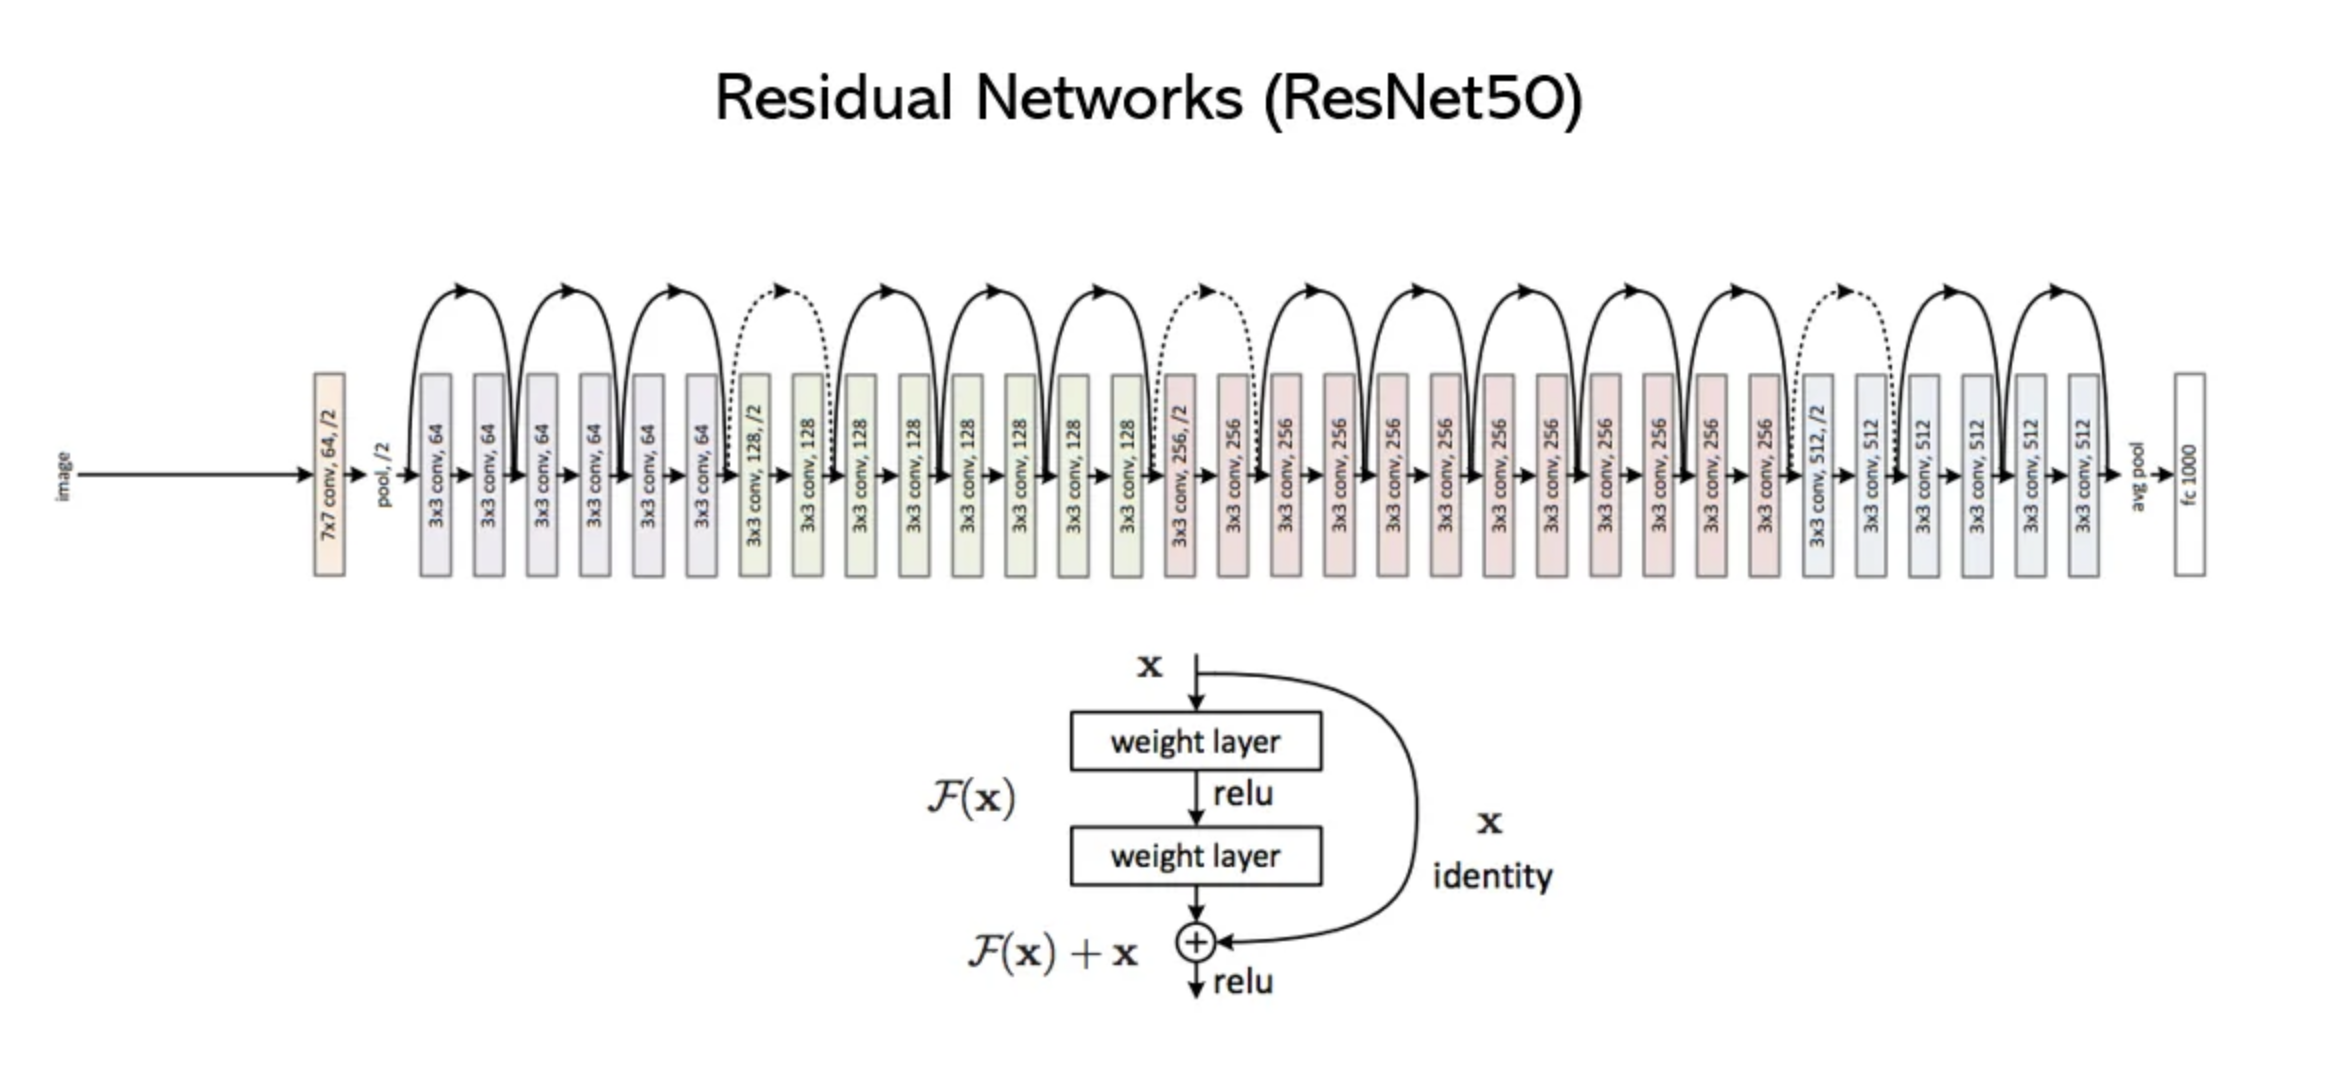
ResNet-50 — это сверточная нейросеть с глубокой архитектурой, предложенная в 2015 году исследователями из Microsoft Research. 
Ключевые особенности:
- Глубина: 50 слоев (включая свёртки, нормализации и активации).
- Остаточные блоки: Вводятся shortcut-соединения (skip connections), которые помогают бороться с деградацией градиента в глубоких сетях.
- Архитектура: Состоит из 4-х стадий по несколько residual-блоков.
- Базовый блок: Bottleneck (три свёртки: 1×1 → 3×3 → 1×1).

Преимущества:
- Лучше обучается при увеличении глубины (по сравнению с обычными CNN).
- Используется как backbone в задачах детекции, сегментации и т.д.


In [125]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

import requests
import warnings
warnings.filterwarnings("ignore")

Импортирую неполный датасет с размеченными (лица выровнены) данными для данной части пайплайна

Посмотрим на его структуру 

In [4]:
! ls celebA_train_500

celebA_anno.txt        celebA_imgs            celebA_train_split.txt


In [7]:
# в анотации должны быть прописаны все отношения между фотографиями и их принадлежности к определенному классу (человеку)
annotations_data= {}

with open("/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_anno.txt", "r") as f:
    for item in f:
        image, key = item.split()
        if key not in annotations_data:
            annotations_data[key] = []
        annotations_data[key].append(image)

annotations_dataframe = pd.DataFrame(list(annotations_data.items()), columns=["person", "images"], )
annotations_dataframe.set_index("person", inplace=True)
annotations_dataframe["count_images"] = annotations_dataframe["images"].apply(lambda images_list: len(images_list))
annotations_dataframe

,images,count_images
person,,
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22


In [9]:
# В данном файле хранятся данные для разбиения на трейновую, валидационную и тестовую выботки
splits = {}

# Чтение файла с разбиением
with open("/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_train_split.txt", "r") as f:
    for line in f:
        image_name, split = line.split()
        splits[image_name] = int(split)  # Сохраняем split как целое число

# Проверим статистику
train_count = sum(1 for v in splits.values() if v == 0)
val_count = sum(1 for v in splits.values() if v == 1)
test_count = sum(1 for v in splits.values() if v == 2)

print(f"Train: {train_count}, Val: {val_count}, Test: {test_count}")


Train: 8544, Val: 1878, Test: 1589


In [11]:
images_name = os.listdir("./celebA_train_500/celebA_imgs/")
len(images_name)

23948

In [13]:
img = Image.open("./celebA_train_500/celebA_imgs/000001.jpg")

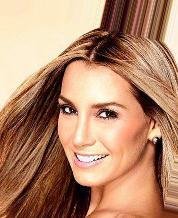

In [15]:
img

In [17]:
class CelebADataset(Dataset):
    def __init__(self, data_dir, image_to_id, splits, target_split, transform=None):
        """
        Args:
            data_dir: Папка с изображениями.
            image_to_id: Словарь, где ключ — имя изображения, значение — id человека.
            splits: Словарь, где ключ — имя изображения, значение — split (0, 1, 2).
            target_split: На какой split ориентироваться ('train', 'val', 'test').
            transform: Преобразования для изображений.
        """
        self.data_dir = data_dir
        self.image_to_id = {
            k: v for k, v in image_to_id.items() if splits[k] == target_split
        }
        self.image_names = list(self.image_to_id.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.image_to_id[img_name]
        if self.transform:
            image = self.transform(image)
        return image, label

In [39]:
# Пути к данным
data_dir = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_imgs"
anno_file = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа//celebA_train_500/celebA_anno.txt"
split_file = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_train_split.txt"

# 1. Читаем аннотации
image_to_id = {}
with open(anno_file, "r") as f:
    for line in f:
        image_name, person_id = line.strip().split()
        image_to_id[image_name] = int(person_id)

# 2. Читаем разбиение
splits = {}
with open(split_file, "r") as f:
    for line in f:
        image_name, split = line.strip().split()
        splits[image_name] = int(split)

# 3. Трансформации
from torchvision import transforms

'''transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])'''


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Датасеты
train_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=0, transform=transform)
val_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=1, transform=transform)
test_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=2, transform=transform)

# 5. DataLoader'ы
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [39]:
train_dataset

In [105]:
num_classes = len(set(image_to_id.values()))  # Количество уникальных ID
num_classes

500

In [69]:
# Загрузка предобученной модели
model = models.resnet34(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Заменяем классификатор

In [71]:
# Устройство
device = torch.device("mps")
model = model.to(device)
device

device(type='mps')

In [100]:


from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Загрузка предобученной модели
model2 = models.resnet50(weights='IMAGENET1K_V1')
model2.fc = nn.Linear(model2.fc.in_features, num_classes)
device = torch.device("mps")
model2 = model2.to(device)
device

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.8)
#optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

# Планировщик
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Каждые 5 эпох уменьшаем lr в 10 раз
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01,  threshold=1e-4)

In [102]:
# Функция для обучения и валидации
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss_sp = []
        val_loss_sp = []

        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_loss_sp.append(train_loss)
        train_acc = train_correct / len(train_loader.dataset)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_loss_sp.append(val_loss)
        val_acc = val_correct / len(val_loader.dataset)

        #scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/Users/olgashalashova/Downloads/best_model.pth")

    print("Лучший результат на валидации:", best_acc)

# Запускаем обучение
train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15
Train Loss: 5.3300, Train Acc: 0.0549
Val Loss: 4.1197, Val Acc: 0.1486
Epoch 2/15
Train Loss: 3.3371, Train Acc: 0.2718
Val Loss: 3.0991, Val Acc: 0.3046
Epoch 3/15
Train Loss: 2.1811, Train Acc: 0.4840
Val Loss: 2.4572, Val Acc: 0.4292
Epoch 4/15
Train Loss: 1.4553, Train Acc: 0.6524
Val Loss: 2.5273, Val Acc: 0.4185
Epoch 5/15
Train Loss: 0.9524, Train Acc: 0.7715
Val Loss: 2.0144, Val Acc: 0.5415
Epoch 6/15
Train Loss: 0.6259, Train Acc: 0.8521
Val Loss: 1.8312, Val Acc: 0.5692
Epoch 7/15
Train Loss: 0.3635, Train Acc: 0.9264
Val Loss: 1.5915, Val Acc: 0.6203
Epoch 8/15
Train Loss: 0.2234, Train Acc: 0.9545
Val Loss: 1.6099, Val Acc: 0.6342
Epoch 9/15
Train Loss: 0.1283, Train Acc: 0.9827
Val Loss: 1.4334, Val Acc: 0.6645
Epoch 10/15
Train Loss: 0.0774, Train Acc: 0.9909
Val Loss: 1.3373, Val Acc: 0.6960
Epoch 11/15
Train Loss: 0.0520, Train Acc: 0.9963
Val Loss: 1.2515, Val Acc: 0.7151
Epoch 12/15
Train Loss: 0.0324, Train Acc: 0.9984
Val Loss: 1.2111, Val Acc: 0.7354
E

In [103]:
test_model(model2, test_loader)

Точность на тесте: 0.7338


Обучим по-новому
=

In [111]:
def detect_and_align_faces(image_path):
    image = cv2.imread(image_path)
    results = yolo_model(image, verbose=False)[0]
    detections = []
    
    for box in results.boxes:
        cls = int(box.cls.item())
        if cls == 0:  # Класс 0 - лицо
            xmin, ymin, xmax, ymax = int(box.xyxy[0][0].item()), int(box.xyxy[0][1].item()), int(box.xyxy[0][2].item()), int(box.xyxy[0][3].item())
            face = image[ymin:ymax, xmin:xmax]
            gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            eyes = eye_cascade.detectMultiScale(gray_face)

            if len(eyes) >= 2:

                eyes = sorted(eyes, key=lambda e: e[0])
                left_eye, right_eye = eyes[0], eyes[1]
        
                left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
                right_eye_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)
        
                delta_x = right_eye_center[0] - left_eye_center[0]
                delta_y = right_eye_center[1] - left_eye_center[1]
                angle_gr = np.arctan2(delta_y, delta_x)
                
                if angle_gr < -1:
                    angle = np.degrees(np.arctan2(delta_y, delta_x) + 1.5)
                elif angle_gr > 1:
                    angle = np.degrees(np.arctan2(delta_y, delta_x) - 1.5)
                else:
                    angle = np.degrees(np.arctan2(delta_y, delta_x))
                desired_dist = 0.4 * face.shape[1]
                current_dist = np.sqrt(delta_x ** 2 + delta_y ** 2)
                scale = desired_dist / current_dist

                        
                center = (
                    int((left_eye_center[0] + right_eye_center[0]) // 2),
                    int((left_eye_center[1] + right_eye_center[1]) // 2)
                )
        
                border_size = int(max(face.shape[:2]) * 0.2)
                face_padded = cv2.copyMakeBorder(face, border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
                center_padded = (center[0] + border_size, center[1] + border_size)
        
                M = cv2.getRotationMatrix2D(center_padded, angle, scale)
                rotated_padded = cv2.warpAffine(
                    face_padded,
                    M,
                    (face_padded.shape[1], face_padded.shape[0]),
                    flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_REFLECT
                )
        
                aligned_face = rotated_padded[
                    border_size:border_size + face.shape[0],
                    border_size:border_size + face.shape[1]
                ]

                detections.append(aligned_face)
    
    return detections


In [149]:
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import numpy as np

# === Пути ===
input_dir = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/img_celeba"
anno_file = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_anno.txt"
output_dir = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/aligned_faces"
os.makedirs(output_dir, exist_ok=True)

# === Загрузка аннотированных имён изображений ===
image_to_id = {}
with open(anno_file, "r") as f:
    for line in f:
        img_name, person_id = line.strip().split()
        image_to_id[img_name] = int(person_id)

annotated_images = set(image_to_id.keys())

def save_aligned_faces():
    image_files = [f for f in os.listdir(input_dir) if f in annotated_images]

    for img_name in tqdm(image_files, desc="Обработка изображений"):
        img_path = os.path.join(input_dir, img_name)

        try:
            aligned_faces = detect_and_align_faces(img_path)
        except Exception as e:
            print(f"[!] Ошибка при обработке {img_name}: {e}")
            aligned_faces = []

        if aligned_faces and aligned_faces[0].size > 0:
            aligned_face = aligned_faces[0]
            save_path = os.path.join(output_dir, img_name)
            cv2.imwrite(save_path, aligned_face)
        else:
            # fallback: сохраняем исходное изображение
            original = cv2.imread(img_path)
            if original is not None:
                save_path = os.path.join(output_dir, img_name)
                cv2.imwrite(save_path, original)
            else:
                print(f"[!] Не удалось прочитать исходное изображение: {img_name}")

save_aligned_faces()


Обработка изображений: 100%|██████████| 12011/12011 [08:26<00:00, 23.72it/s]


In [151]:
class CelebADataset(Dataset):
    def __init__(self, data_dir, image_to_id, splits, target_split, transform=None):
        """
        Args:
            data_dir: Папка с изображениями.
            image_to_id: Словарь, где ключ — имя изображения, значение — id человека.
            splits: Словарь, где ключ — имя изображения, значение — split (0, 1, 2).
            target_split: На какой split ориентироваться ('train', 'val', 'test').
            transform: Преобразования для изображений.
        """
        self.data_dir = data_dir
        self.image_to_id = {
            k: v for k, v in image_to_id.items() if splits[k] == target_split
        }
        self.image_names = list(self.image_to_id.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.image_to_id[img_name]
        if self.transform:
            image = self.transform(image)
        return image, label

In [153]:
# Пути к данным
data_dir = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_imgs"
anno_file = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа//celebA_train_500/celebA_anno.txt"
split_file = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_train_500/celebA_train_split.txt"
aligned_data_dir = "/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/aligned_faces"

# 1. Читаем аннотации
image_to_id = {}
with open(anno_file, "r") as f:
    for line in f:
        image_name, person_id = line.strip().split()
        image_to_id[image_name] = int(person_id)

# 2. Читаем разбиение
splits = {}
with open(split_file, "r") as f:
    for line in f:
        image_name, split = line.strip().split()
        splits[image_name] = int(split)

# 3. Трансформации
from torchvision import transforms

'''transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])'''


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Датасеты
train_dataset = CelebADatasetAligned(aligned_data_dir, image_to_id, splits, target_split=0, transform=transform)
val_dataset = CelebADatasetAligned(aligned_data_dir, image_to_id, splits, target_split=1, transform=transform)
test_dataset = CelebADatasetAligned(aligned_data_dir, image_to_id, splits, target_split=2, transform=transform)

# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [155]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Загрузка предобученной модели
model3 = models.resnet50(weights='IMAGENET1K_V1')
model3.fc = nn.Linear(model3.fc.in_features, num_classes)
device = torch.device("mps")
model3 = model3.to(device)
device

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.8)
#optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

# Планировщик
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Каждые 5 эпох уменьшаем lr в 10 раз
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01,  threshold=1e-4)

In [156]:
# Функция для обучения и валидации
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss_sp = []
        val_loss_sp = []

        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_loss_sp.append(train_loss)
        train_acc = train_correct / len(train_loader.dataset)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_loss_sp.append(val_loss)
        val_acc = val_correct / len(val_loader.dataset)

        #scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/Users/olgashalashova/Downloads/best_model.pth")

    print("Лучший результат на валидации:", best_acc)

# Запускаем обучение
train_model(model3, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15
Train Loss: 5.9221, Train Acc: 0.0205
Val Loss: 5.3255, Val Acc: 0.0596
Epoch 2/15
Train Loss: 4.7992, Train Acc: 0.1058
Val Loss: 4.7651, Val Acc: 0.1145
Epoch 3/15
Train Loss: 3.9103, Train Acc: 0.2379
Val Loss: 4.1953, Val Acc: 0.1922
Epoch 4/15
Train Loss: 3.2782, Train Acc: 0.3536
Val Loss: 4.0743, Val Acc: 0.2391
Epoch 5/15
Train Loss: 2.8326, Train Acc: 0.4479
Val Loss: 3.9160, Val Acc: 0.2583
Epoch 6/15
Train Loss: 2.4892, Train Acc: 0.5275
Val Loss: 3.9352, Val Acc: 0.2913
Epoch 7/15
Train Loss: 2.2229, Train Acc: 0.5928
Val Loss: 3.8752, Val Acc: 0.2907
Epoch 8/15
Train Loss: 2.0037, Train Acc: 0.6463
Val Loss: 3.6904, Val Acc: 0.3323
Epoch 9/15
Train Loss: 1.8466, Train Acc: 0.6877
Val Loss: 3.5659, Val Acc: 0.3695
Epoch 10/15
Train Loss: 1.7576, Train Acc: 0.7089
Val Loss: 3.5961, Val Acc: 0.3647
Epoch 11/15
Train Loss: 1.7030, Train Acc: 0.7216
Val Loss: 3.3952, Val Acc: 0.3978
Epoch 12/15
Train Loss: 1.6848, Train Acc: 0.7227
Val Loss: 3.2590, Val Acc: 0.4212
E

In [163]:
def test_model(model, test_loader):
    model.load_state_dict(torch.load("/Users/olgashalashova/Downloads/best_model.pth"))
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()

    test_acc = test_correct / len(test_loader.dataset)
    print(f"Точность на тесте: {test_acc:.4f}")
test_model(model3, test_loader)

Точность на тесте: 0.4135


Реализовать Identification Rate Metric (2 балла)
==

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [112]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict
import os

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_ir/celebA_distractors')

In [114]:
query_dict['35']

['001265.jpg',
 '001430.jpg',
 '012834.jpg',
 '041171.jpg',
 '041823.jpg',
 '052547.jpg',
 '071369.jpg',
 '087722.jpg',
 '101493.jpg',
 '113930.jpg',
 '133927.jpg',
 '136309.jpg',
 '140075.jpg',
 '153974.jpg',
 '154402.jpg',
 '161094.jpg']

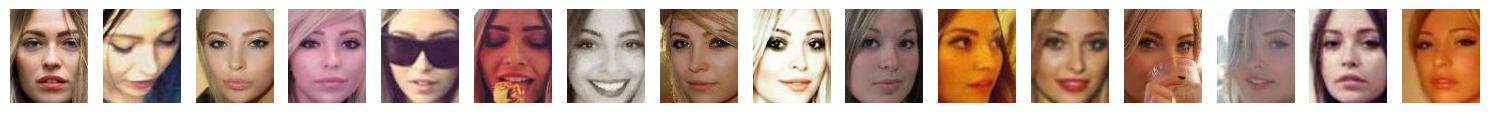

In [130]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(nrows=1, ncols=len(query_dict['35']), figsize=(15, 5))

for i, img_path in enumerate(query_dict['35']):
    img = mpimg.imread(f"./celebA_ir/celebA_query/{img_path}")
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [134]:
import torch
from PIL import Image
from torchvision import transforms
import os

def compute_embeddings(model, images_list, image_dir):
    '''
    Compute embeddings from the trained model for list of images.

    Params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of image names (not full paths) to compute embeddings for
        image_dir: directory where the images are stored

    Output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_list
    '''
    # Переводим модель в режим инференса (без обучения)
    model.eval()

    # Определяем трансформации изображений: resize, normalize, и преобразование в тензор
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.5, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    embeddings = []  

    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        for img_name in images_list:
            img_path = os.path.join(image_dir, img_name)

            if os.path.exists(img_path):  
                image = Image.open(img_path).convert('RGB')

                input_tensor = transform(image).unsqueeze(0)  # Добавляем batch dimension (сделаем размерность [1, C, H, W])

                input_tensor = input_tensor.to(device)
                
                embedding = feature_extractor(input_tensor)

                embeddings.append(embedding.squeeze().cpu().numpy())
            else:
                print(f"Warning: {img_path} does not exist!")

    return embeddings

query_image_dir = '/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_ir/celebA_query'  
distractors_image_dir = '/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/celebA_ir/celebA_distractors'  

query_embeddings = compute_embeddings(model, query_img_names, query_image_dir)
distractors_embeddings = compute_embeddings(model, distractors_img_names, distractors_image_dir)


**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [138]:
import torch
import torch.nn.functional as F

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to the same people from query list
    '''
    similarities = []
    
    for img_class, img_names in query_dict.items(): #нам дан словарь, где ключ - это индекс, а значение - индекс фотографий
        indices = [query_img_names.index(img_name) for img_name in img_names]
        
        embeddings = [query_embeddings[i] for i in indices]
        
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                similarity = F.cosine_similarity(torch.tensor(embeddings[i]).unsqueeze(0),
                                                 torch.tensor(embeddings[j]).unsqueeze(0))
                similarities.append(similarity.item())
    
    return similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    '''
    similarities = []
    
    all_classes = list(query_dict.keys())
    
    for i in range(len(all_classes)):
        for j in range(i + 1, len(all_classes)):
            class_a = all_classes[i]
            class_b = all_classes[j]
            
            img_names_a = query_dict[class_a]
            img_names_b = query_dict[class_b]
            
            indices_a = [query_img_names.index(img_name) for img_name in img_names_a]
            indices_b = [query_img_names.index(img_name) for img_name in img_names_b]
            
            embeddings_a = [query_embeddings[i] for i in indices_a]
            embeddings_b = [query_embeddings[i] for i in indices_b]
            
            for emb_a in embeddings_a:
                for emb_b in embeddings_b:
                    similarity = F.cosine_similarity(torch.tensor(emb_a).unsqueeze(0),
                                                     torch.tensor(emb_b).unsqueeze(0))
                    similarities.append(similarity.item())
    
    return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
        list of floats: similarities between pairs of people (q, d), where q is
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors
    '''
    similarities = []
    
    for q_emb in query_embeddings:
        for d_emb in distractors_embeddings:
            similarity = F.cosine_similarity(torch.tensor(q_emb).unsqueeze(0),
                                             torch.tensor(d_emb).unsqueeze(0))
            similarities.append(similarity.item())
    
    return similarities


In [140]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


In [141]:
import numpy as np
import math

def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    
    all_negative_similarities = np.concatenate([cosine_query_neg, cosine_query_distractors])

    # Количество false пар 
    num_false_pairs = len(all_negative_similarities)

    sorted_neg_similarities = -np.sort(-all_negative_similarities)

    
    N = int(fpr * num_false_pairs)  
    
    threshold = sorted_neg_similarities[N]

    num_true_positives = sum([1 for similarity in cosine_query_pos if similarity > threshold])
    
    tpr = num_true_positives / len(cosine_query_pos)

    return threshold, tpr

4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [145]:
all_thr = []
all_tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
  x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=fpr)
  all_thr.append(x)
  all_tpr.append(y)

all_tpr

[0.7451260104612458,
 0.47360912981455067,
 0.3264723863867944,
 0.2225392296718973]

Соберем наш пайплайн
==
- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).


0: 288x320 1 face, 33.3ms
Speed: 1.3ms preprocess, 33.3ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 320)
Распознан ID: 28


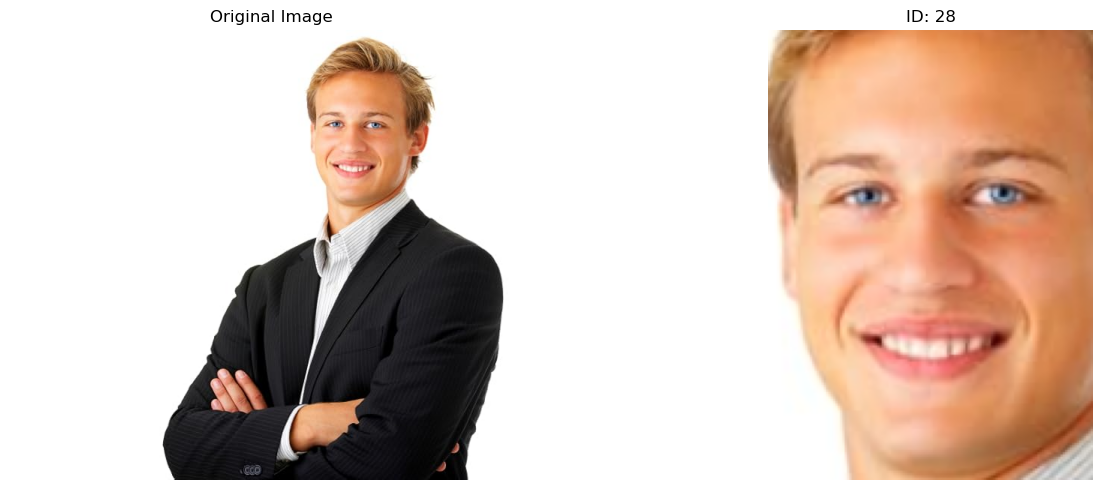

In [46]:
import cv2
import numpy as np
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from torchvision import models, transforms
from PIL import Image

# ==== Загрузка обученной модели для распознавания ====
recognition_model = models.resnet50(weights='IMAGENET1K_V1')
recognition_model.fc = torch.nn.Linear(recognition_model.fc.in_features, 500)
recognition_model.load_state_dict(torch.load("/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/best_model_recognition.pth"))
recognition_model.eval()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ==== Загрузка изображения ====
image_url = 'https://m.media-amazon.com/images/I/71ZMQFkS0cL._SY600_.jpg'
response = requests.get(image_url, stream=True).raw
image = np.asarray(bytearray(response.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

# ==== YOLOv8 для детекции лиц ====
model_path = '/Users/olgashalashova/Documents/ВУЗ/Курсовая работа/runs/detect/train58/weights/best.pt'
yolo_model = YOLO(model_path)

results = yolo_model(image)[0]
detections = []
for box in results.boxes:
    cls = int(box.cls.item())
    if cls == 0:
        detections.append({
            'xmin': box.xyxy[0][0].item(),
            'ymin': box.xyxy[0][1].item(),
            'xmax': box.xyxy[0][2].item(),
            'ymax': box.xyxy[0][3].item(),
            'confidence': box.conf.item(),
            'class': cls,
            'class_name': yolo_model.names[cls]
        })

res_df = pd.DataFrame(detections)

# ==== Каскад Хаара для глаз ====
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

aligned_faces = []
recognized_ids = []

# ==== Обработка каждого найденного лица ====
for _, row in res_df.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    face = image[ymin:ymax, xmin:xmax]
    gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    eyes = eye_cascade.detectMultiScale(gray_face)

    if len(eyes) >= 2:
        eyes = sorted(eyes, key=lambda e: e[0])
        left_eye, right_eye = eyes[0], eyes[1]

        left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
        right_eye_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)

        delta_x = right_eye_center[0] - left_eye_center[0]
        delta_y = right_eye_center[1] - left_eye_center[1]
        angle_gr = np.arctan2(delta_y, delta_x)

        if angle_gr < -1:
            angle = np.degrees(np.arctan2(delta_y, delta_x) + 1.5)
        elif angle_gr > 1:
            angle = np.degrees(np.arctan2(delta_y, delta_x) - 1.5)
        else:
            angle = np.degrees(np.arctan2(delta_y, delta_x))

        desired_dist = 0.4 * face.shape[1]
        current_dist = np.sqrt(delta_x ** 2 + delta_y ** 2)
        scale = desired_dist / current_dist

        center = (
            int((left_eye_center[0] + right_eye_center[0]) // 2),
            int((left_eye_center[1] + right_eye_center[1]) // 2)
        )

        border_size = int(max(face.shape[:2]) * 0.2)
        face_padded = cv2.copyMakeBorder(face, border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
        center_padded = (center[0] + border_size, center[1] + border_size)

        M = cv2.getRotationMatrix2D(center_padded, angle, scale)
        rotated_padded = cv2.warpAffine(
            face_padded,
            M,
            (face_padded.shape[1], face_padded.shape[0]),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REFLECT
        )

        aligned_face = rotated_padded[
            border_size:border_size + face.shape[0],
            border_size:border_size + face.shape[1]
        ]

        # ==== Распознавание лица ====
        face_pil = Image.fromarray(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
        face_tensor = transform(face_pil).unsqueeze(0)

        with torch.no_grad():
            output = recognition_model(face_tensor)
            _, predicted = torch.max(output, 1)
            predicted_id = predicted.item()
            print(f'Распознан ID: {predicted_id}')

        aligned_faces.append(aligned_face)
        recognized_ids.append(predicted_id)

# ==== Визуализация ====
fig, axes = plt.subplots(1, len(aligned_faces) + 1, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, face in enumerate(aligned_faces):
    axes[i + 1].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f'ID: {recognized_ids[i]}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()
